# Election data

In [80]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import DbConnection as db
from scipy import stats
from algorithms import *
from sqlalchemy import MetaData, create_engine
from sqlalchemy.orm import sessionmaker

In [96]:
# query: group by por municipio total inscritos, total votos validos, total votos por el MAS y votos CC 2019 2020

In [97]:
query_last_mesas = "SELECT mesa_pk FROM votos WHERE fecha_hora_actualizacion = (SELECT MAX(fecha_hora_actualizacion) FROM votos)"
last_mesas_df = pd.read_sql(query_last_mesas, con=db.engine).drop_duplicates()
last_mesas_df.shape

(35463, 1)

In [98]:
query_last_votes_per_parties = "SELECT parties_table.elecciones_pk, departamento_pk, parties_table.municipio_pk, parties_table.recinto_pk, parties_table.mesa_pk, \
parties_table.partido_pk, municipio, recinto, fecha_hora_actualizacion, nombre as partido, inscritos, cantidad FROM (SELECT elecciones_pk,departamento_pk,municipio_pk,\
recinto_pk,mesa_pk,partido_pk,fecha_hora_actualizacion,cantidad FROM votos WHERE tipo_de_voto='presidencial' AND fecha_hora_actualizacion=(SELECT MAX(fecha_hora_actualizacion) FROM votos))\
as parties_table INNER JOIN partido ON parties_table.partido_pk=partido.partido_pk \
INNER JOIN (SELECT mesa_pk,inscritos FROM mesa) as mesas_table ON parties_table.mesa_pk = mesas_table.mesa_pk \
INNER JOIN (SELECT municipio_pk,nombre as municipio FROM municipio) as municipio_table ON parties_table.municipio_pk=municipio_table.municipio_pk \
INNER JOIN (SELECT recinto_pk,nombre as recinto FROM recinto) as recinto_table ON parties_table.recinto_pk=recinto_table.recinto_pk ;"
last_votes_parties_df = pd.read_sql(query_last_votes_per_parties, con=db.engine).rename(
    {"nombre": "partido"}
)
[
    (last_votes_parties_df["partido"] != "blancos")
    & (last_votes_parties_df["partido"] != "nulos")
]
last_votes_parties_df

elecciones_pk  departamento_pk  municipio_pk  recinto_pk  mesa_pk  \
0                   9                2             2          83     1024   
1                   9                2             2        3395     1072   
2                   9                2             2        3395     1073   
3                   9                2             2        3395     1074   
4                   9                2             2        3395     1075   
...               ...              ...           ...         ...      ...   
207463              9                5            75        1693     1626   
207464              9                5            75        1693     1627   
207465              9                5            75        1693     1628   
207466              9                5            75        1693     1629   
207467              9                5            75        1693     1630   

        partido_pk          municipio  \
0                1  c.a. buenos aires   
1                1  c.a. buenos aires   
2                1  c.a. buenos aires   
3                1  c.a. buenos aires   
4                1  c.a. buenos aires   
...            ...                ...   
207463           1              salta   
207464           1              salta   
207465           1              salta   
207466           1              salta   
207467           1              salta   

                                                  recinto  \
0       escuela tecnica n 29 d.e. 06 reconquista de bu...   
1                    escuela n 3 de 20 republica francesa   
2                    escuela n 3 de 20 republica francesa   
3                    escuela n 3 de 20 republica francesa   
4                    escuela n 3 de 20 republica francesa   
...                                                   ...   
207463                      colegio nacional salta n 5080   
207464                      colegio nacional salta n 5080   
207465                      colegio nacional salta n 5080   
207466                      colegio nacional salta n 5080   
207467                      colegio nacional salta n 5080   

       fecha_hora_actualizacion  partido  inscritos  cantidad  
0           2020-10-23 09:28:00  creemos        220         2  
1           2020-10-23 09:28:00  creemos        220         2  
2           2020-10-23 09:28:00  creemos        220         7  
3           2020-10-23 09:28:00  creemos        220         3  
4           2020-10-23 09:28:00  creemos        220         7  
...                         ...      ...        ...       ...  
207463      2020-10-23 09:28:00  creemos        220         3  
207464      2020-10-23 09:28:00  creemos        220         5  
207465      2020-10-23 09:28:00  creemos        220         3  
207466      2020-10-23 09:28:00  creemos        220         2  
207467      2020-10-23 09:28:00  creemos        220         7  

[207468 rows x 12 columns]

In [99]:
last_votes_parties_df["partido"].drop_duplicates()

0          creemos
28131          adn
28447          mas
63957          fpv
93347      pan_bol
110845    libre_21
111136          cc
145723     blancos
172746       nulos
Name: partido, dtype: object

In [100]:
mesas_emitted_votes_df = (
    last_votes_parties_df.groupby("mesa_pk", as_index=False)
    .agg({"cantidad": sum})
    .rename({"cantidad": "cantidad_votos_validos"}, axis=1)
)
mesas_emitted_votes_df

mesa_pk  cantidad_votos_validos
0         1001                     141
1         1002                      34
2         1003                     137
3         1004                     133
4         1005                     157
...        ...                     ...
35458    90399                     187
35459    90400                     174
35460    90401                      92
35461    90402                     149
35462    90403                      53

[35463 rows x 2 columns]

In [101]:
last_votes_mesa_data_df = last_votes_parties_df.merge(
    mesas_emitted_votes_df, on="mesa_pk", how="inner"
)
last_votes_mesa_data_df

elecciones_pk  departamento_pk  municipio_pk  recinto_pk  mesa_pk  \
0                   9                2             2          83     1024   
1                   9                2             2          83     1024   
2                   9                2             2          83     1024   
3                   9                2             2          83     1024   
4                   9                2             2          83     1024   
...               ...              ...           ...         ...      ...   
207463              9               27           327        2941    90382   
207464              9               27           327        2941    90382   
207465              9               27           327        2941    90382   
207466              9               27           327        2941    90382   
207467              9               27           327        2941    90382   

        partido_pk          municipio  \
0                1  c.a. buenos aires   
1               16  c.a. buenos aires   
2                3  c.a. buenos aires   
3               17  c.a. buenos aires   
4                4  c.a. buenos aires   
...            ...                ...   
207463          16    nueva esperanza   
207464           3    nueva esperanza   
207465          17    nueva esperanza   
207466          14    nueva esperanza   
207467          15    nueva esperanza   

                                                  recinto  \
0       escuela tecnica n 29 d.e. 06 reconquista de bu...   
1       escuela tecnica n 29 d.e. 06 reconquista de bu...   
2       escuela tecnica n 29 d.e. 06 reconquista de bu...   
3       escuela tecnica n 29 d.e. 06 reconquista de bu...   
4       escuela tecnica n 29 d.e. 06 reconquista de bu...   
...                                                   ...   
207463                                  u.e.  monte sinai   
207464                                  u.e.  monte sinai   
207465                                  u.e.  monte sinai   
207466                                  u.e.  monte sinai   
207467                                  u.e.  monte sinai   

       fecha_hora_actualizacion  partido  inscritos  cantidad  \
0           2020-10-23 09:28:00  creemos        220         2   
1           2020-10-23 09:28:00      mas        220        89   
2           2020-10-23 09:28:00      fpv        220         5   
3           2020-10-23 09:28:00  pan_bol        220         1   
4           2020-10-23 09:28:00       cc        220        32   
...                         ...      ...        ...       ...   
207463      2020-10-23 09:28:00      mas        184       131   
207464      2020-10-23 09:28:00      fpv        184         3   
207465      2020-10-23 09:28:00  pan_bol        184         1   
207466      2020-10-23 09:28:00  blancos        184         4   
207467      2020-10-23 09:28:00    nulos        184         2   

        cantidad_votos_validos  
0                          129  
1                          129  
2                          129  
3                          129  
4                          129  
...                        ...  
207463                     141  
207464                     141  
207465                     141  
207466                     141  
207467                     141  

[207468 rows x 13 columns]

In [102]:
last_votes_mesa_data_df.loc[:, "porcentaje_participacion"] = (
    last_votes_mesa_data_df["cantidad_votos_validos"]
    * 100
    / last_votes_mesa_data_df["inscritos"].round()
).round()

In [103]:
last_votes_mesa_data_df.loc[:, "porcentaje_partido"] = (
    last_votes_mesa_data_df["cantidad"] * 100 / last_votes_mesa_data_df["inscritos"]
).round()
last_votes_mesa_data_df = last_votes_mesa_data_df[
    (last_votes_mesa_data_df["partido"] != "blancos")
    & (last_votes_mesa_data_df["partido"] != "nulos")
]

In [104]:
municipio_ins_agg = last_votes_mesa_data_df.groupby("municipio").agg({"inscritos": sum})
municipio_ins_agg.head(20)

inscritos
municipio                       
acasio                      8108
achacachi                 111879
achocalla                  68645
aioc charagua iyambae      58100
aioc raqaypampa             6342
aioc uru chipaya            3669
aiquile                    55045
alalay                      4035
alcala                      6559
alto beni                  18266
andamarca                   8175
antequera                   7312
anzaldo                    13343
apolo                      40090
arampampa                   3288
arani                      31450
arbieto                    34750
arlington                  13551
arque                      14103
ascencion de guarayos      67590

In [105]:
partido_groups = last_votes_mesa_data_df.groupby("partido")

## Calculating turnout and percentage of votes for winner

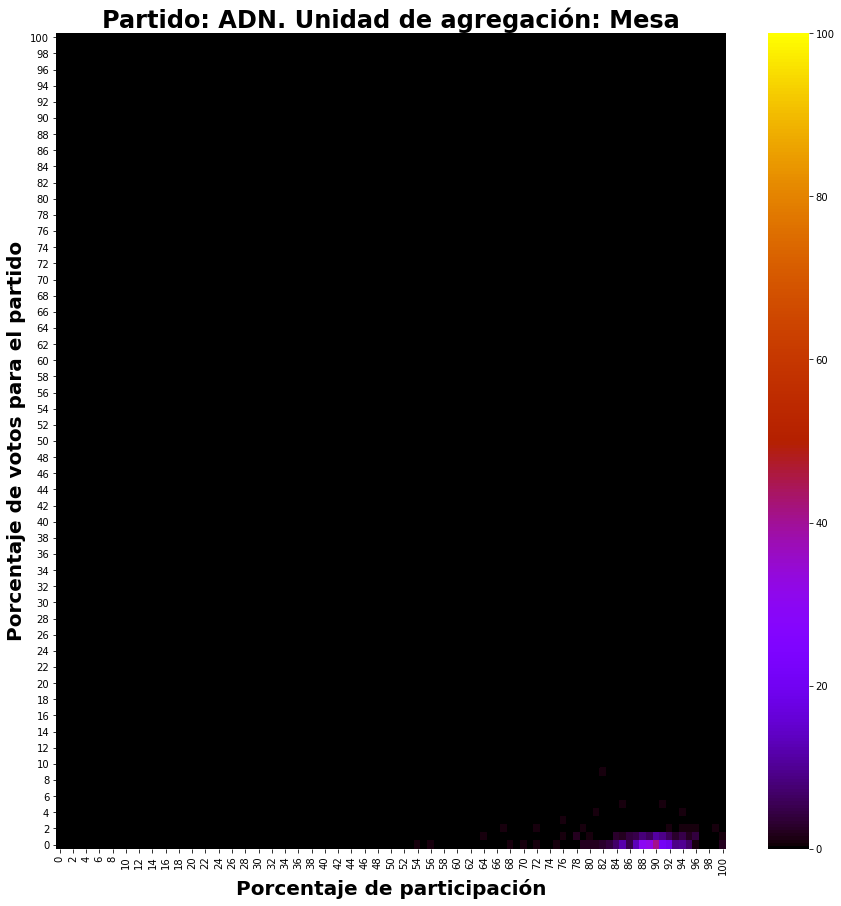

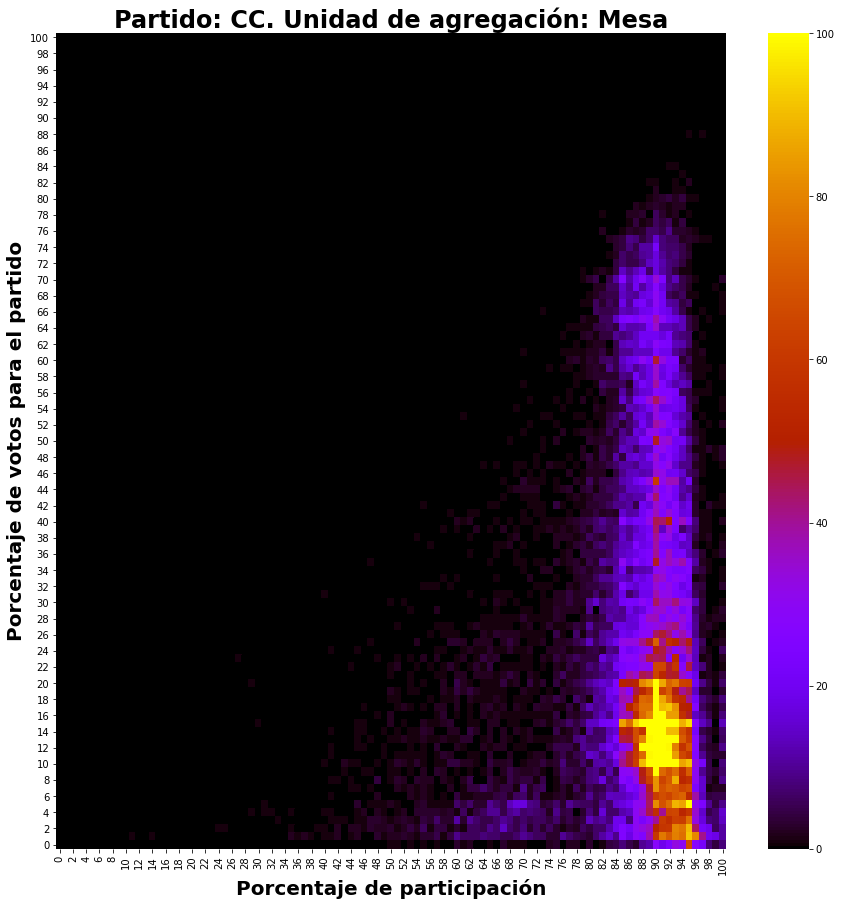

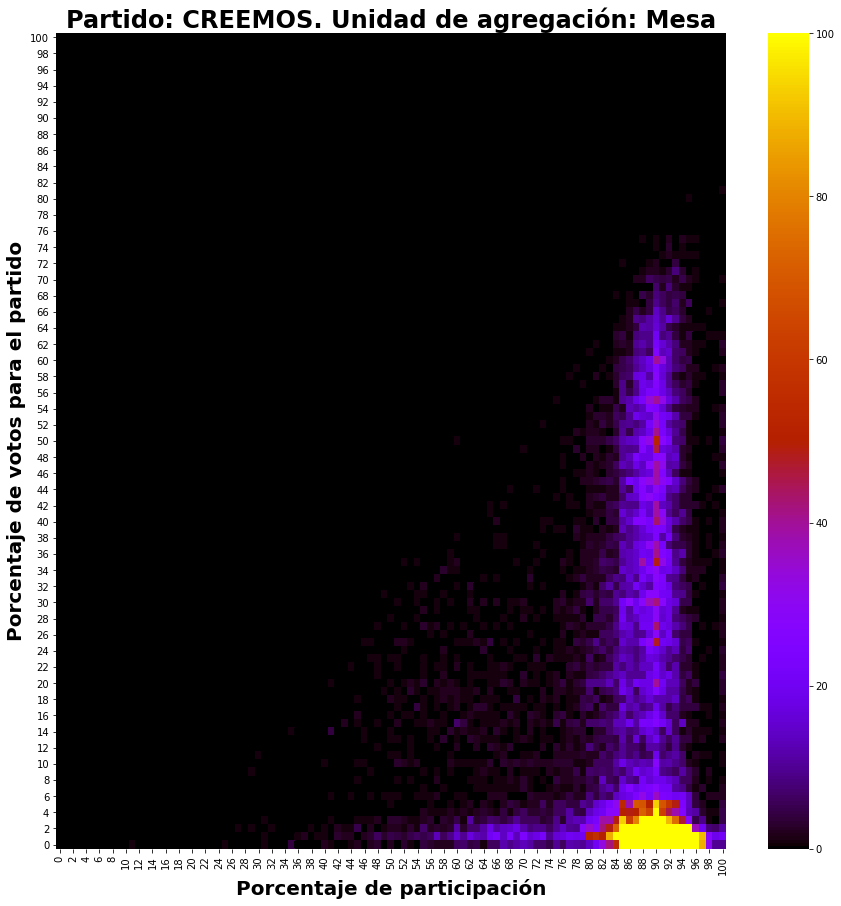

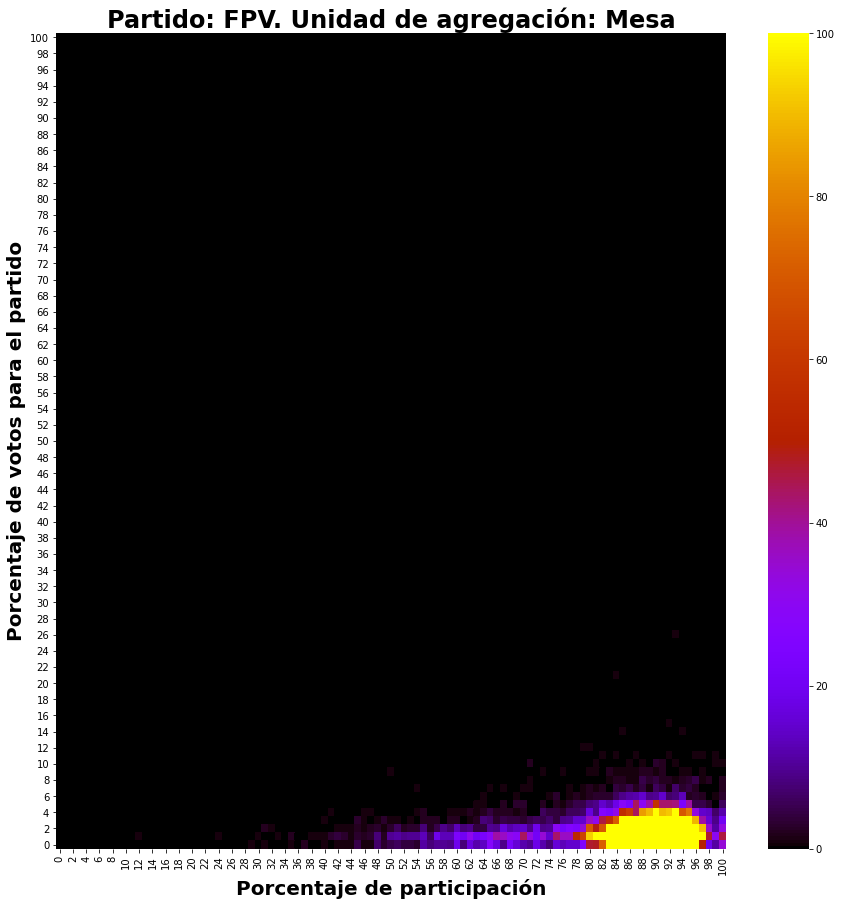

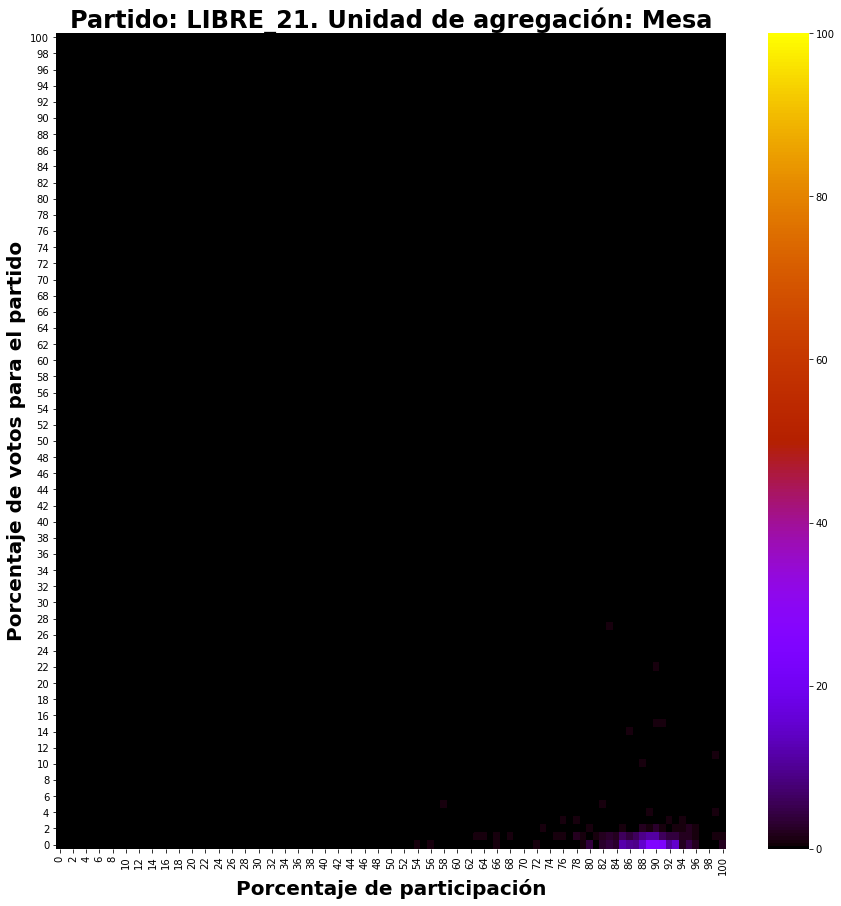

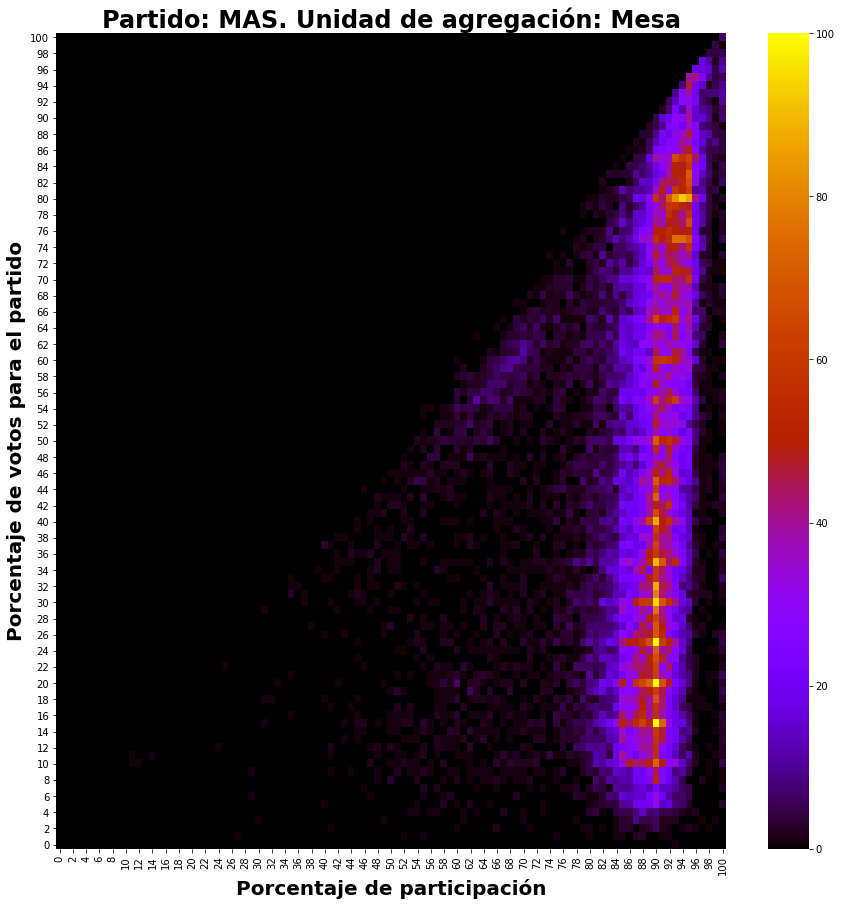

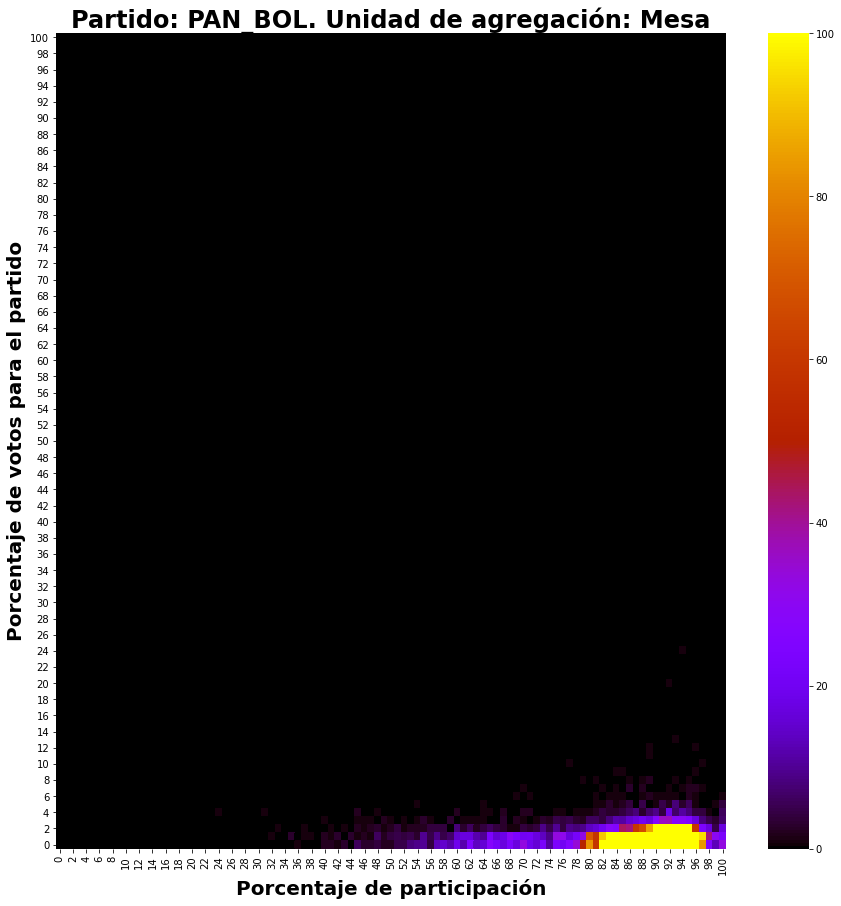

In [106]:
sum_mesas = 0
VMIN = 0
VMAX = 100
center = (VMAX + VMIN) / 2
for (partido, df) in partido_groups:
    fgp_df, vote_units_df, fgp_fig = plot_fingerprint(
        df,
        "porcentaje_partido",
        "porcentaje_participacion",
        unit="Mesa",
        title="Partido: " + partido.upper(),
        keep_cols=["municipio", "recinto"],
        vmin=VMIN,
        center=center,
        vmax=VMAX,
    )
    sum_mesas = sum_mesas + fgp_df.values.sum()
    fgp_fig.savefig("fingerprint " + partido + ".png", dpi=1200, format="png")
    vote_units_df.to_csv("vote_units_" + partido + ".csv", index=False)

6160109


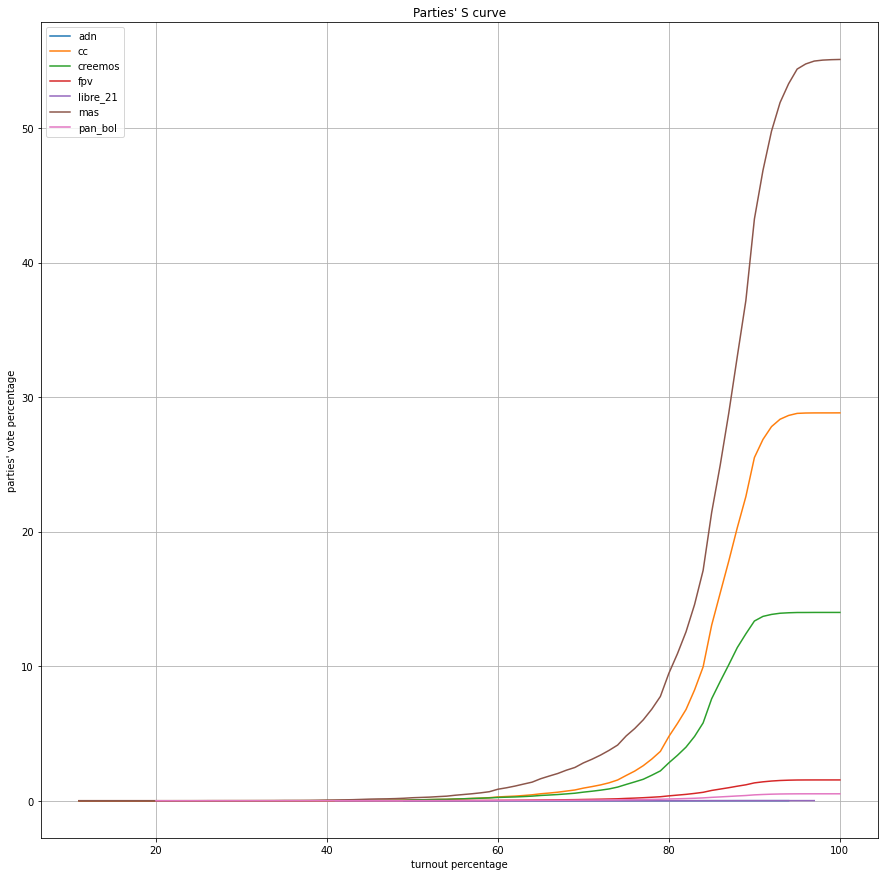

In [110]:
s_curve_fig, s_curve_df = plot_s_curves(
    last_votes_mesa_data_df[
        (last_votes_mesa_data_df["partido"] != "blancos")
        & (last_votes_mesa_data_df["partido"] != "nulos")
    ],
    "mesa_pk",
    "partido",
    "cantidad",
    "inscritos",
    official_percentage=True,
)